# Vehicle Detection Project

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

In [1]:
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from scipy.ndimage.measurements import label
from moviepy.editor import VideoFileClip
from matplotlib.image import imread
import glob
import time
from sklearn.externals import joblib
%matplotlib inline

## import data

In [2]:
vehicle_filenames = glob.glob('./images/vehicles/**/*.png')
non_vehicle_filenames = glob.glob('./images/non-vehicles/**/*.png')

print('size of vehicle images', len(vehicle_filenames))
print('size of non vehicle images', len(non_vehicle_filenames))

size of vehicle images 8792
size of non vehicle images 8968


show some images

In [3]:
def plot_images(images, rows=None, columns=None, titles=None, axis='on',cmap=None, figsize=(14,10)):
    plt.figure(figsize=figsize)
    rows = 1 if rows is None else rows
    columns = len(images) / rows if columns is None else columns
    for i, image in enumerate(images):
        plt.subplot(rows, columns, i + 1)
        if titles is not None:
            title = titles[i].split('/')[-1]
            plt.title(title)
        plt.axis(axis)
        if cmap:
            plt.imshow(image, cmap=cmap)
        elif len(image.shape) == 2:
            plt.imshow(image, cmap='hot')
        else:
            plt.imshow(image)
    plt.show()
    

def plot_random_image_files(image_files, sample_size = 8, rows=2,columns=4):
    samples = np.random.choice(image_files, sample_size)
    images = [imread(sample) for sample in samples]
    plot_images(images, titles = samples,rows=rows,columns=columns)

### Show example of vehicle and non vehicle images:

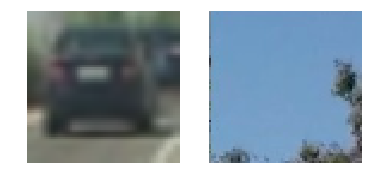

In [51]:
samples = [vehicle_filenames[0], non_vehicle_filenames[0]]
images = [imread(sample) for sample in samples]
plot_images(images, rows=1,columns=2,axis='off', figsize=(6,8))

## Extract HOG features

In [52]:
def hog_images(filenames, sample_size):
    samples = np.random.choice(filenames, sample_size)
    images = []
    titles = []
    for sample in samples:
        image = imread(sample)
        ycrcb = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        _, hog_image_0 = hog(ycrcb[:,:,0], 8, (8,8),(2,2), visualise=True)
        _, hog_image_1 = hog(ycrcb[:,:,1], 8, (8,8),(2,2), visualise=True)
        _, hog_image_2 = hog(ycrcb[:,:,2], 8, (8,8),(2,2), visualise=True)
        images.extend([image, hog_image_0, hog_image_1, hog_image_2])
        titles.extend(['original','y channel','cr channel', 'cb channel'])
        
    return images, titles
        

### Show vehicle images and hog features

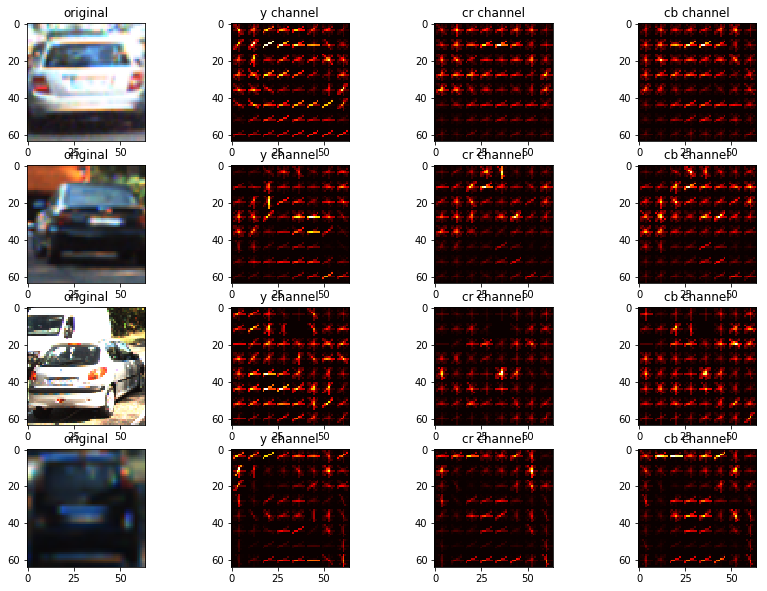

In [53]:
images, titles = hog_images(vehicle_filenames, 4)
plot_images(images, rows=4, columns=4, titles=titles)

### Show non vehicle images and hog features

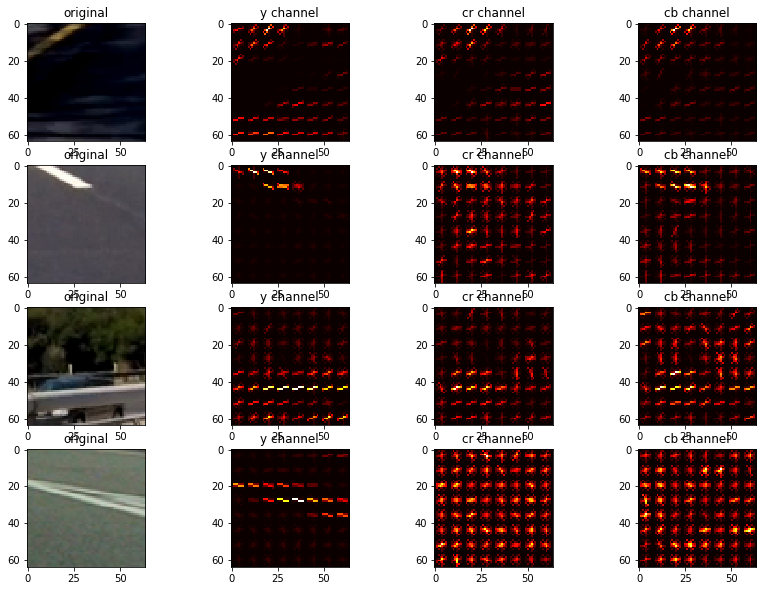

In [8]:
images, titles = hog_images(non_vehicle_filenames, 4)
plot_images(images, rows=4,columns=4, titles=titles)

## Train SVM classifiers

In [9]:
def convert_color(image, color):
    if color == 'YCrcb':
        return cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    if color == 'HLS':
        return cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    if color == 'HSV':
        return cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    if color == 'LUV':
        return cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
    if color == 'YUV':
        return cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
    return np.copy(image)

def bin_spatial(image, size=(32,32)):
    channel1 = cv2.resize(image[:,:,0], size).ravel()
    channel2 = cv2.resize(image[:,:,1], size).ravel()
    channel3 = cv2.resize(image[:,:,2], size).ravel()
    
    spatial_features = np.hstack((channel1, channel2, channel3))
    return spatial_features

def color_hist(image, nbins=32, bins_range=(0,256)):
    channel1_hist = np.histogram(image[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(image[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(image[:,:,2], bins=nbins, range=bins_range)
    
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    return hist_features

def hog_features(image, orient, pixel_per_cell, cell_per_block, vis=False, feature_vec=True):
    hog1 = hog(image[:,:,0], orient, pixels_per_cell=(pixel_per_cell, pixel_per_cell), cells_per_block=(cell_per_block, cell_per_block), visualise=vis, feature_vector=feature_vec)
    hog2 = hog(image[:,:,1], orient, (pixel_per_cell, pixel_per_cell), (cell_per_block, cell_per_block), visualise=vis, feature_vector=feature_vec)
    hog3 = hog(image[:,:,2], orient, (pixel_per_cell, pixel_per_cell), (cell_per_block, cell_per_block), visualise=vis, feature_vector=feature_vec)
    
    hog_features = np.concatenate((hog1,hog2,hog3))
    return hog_features

def extract_image_features(image, cspace='RGB',with_bin_spatial=True, with_color_hist=True, with_hog_features=True,orient=9):
    features = []
    feature_image = convert_color(image, cspace)
    if with_bin_spatial:
        features.extend(bin_spatial(feature_image))
    if with_color_hist:
        features.extend(color_hist(feature_image))
    if with_hog_features:
        features.extend(hog_features(feature_image, orient=orient, pixel_per_cell=8, cell_per_block=2))
    
    return features

def extract_features(images, cspace='RGB', with_bin_spatial=True, with_color_hist=True, with_hog_features=True, orient=9):
    features = []
    for img in images:
        features.append(extract_image_features(img, cspace, with_bin_spatial, with_color_hist, with_hog_features, orient))
    
    return features
    
def train(car_features, non_car_features):
    X = np.vstack((car_features, non_car_features)).astype(np.float64)
    scaler = StandardScaler().fit(X)
    X_scaled = scaler.transform(X)
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(non_car_features))))
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2,random_state=rand_state)
    svc = LinearSVC()
    start = time.time()
    svc.fit(X_train, y_train)
    end = time.time()
    score = svc.score(X_test, y_test)
    return score, end - start,svc, scaler


In [10]:
parameters = [[False, False, True, 7],
             [False, False, True, 8],
             [False, False, True, 9],
             [True, False, False, 0],
             [False,True, False, 0],
             [False, True, True, 8],
             [True, False, True, 8],
             [True, True, False, 0],
             [True, True, True, 8]]

cspaces = ['RGB','YCrcb','HLS', 'HSV', 'LUV','YUV']
vehicle_images = [imread(file) for file in vehicle_filenames]
non_vehicle_images = [imread(file) for file in non_vehicle_filenames]

for p in parameters:
    for c in cspaces:
        car_features = extract_features(vehicle_images, cspace=c, with_bin_spatial=p[0], with_color_hist=p[1], with_hog_features=p[2], orient=p[3])
        non_car_features = extract_features(non_vehicle_images, cspace=c, with_bin_spatial=p[0], with_color_hist=p[1], with_hog_features=p[2], orient=p[3])
        score, cost,_,_ = train(car_features, non_car_features)
        print('parameter {} colorspace {} with score {:.3f} in {:.2f} seconds'.format(p, c, score, cost) )
        



parameter [False, False, True, 7] colorspace RGB with score 0.964 in 19.82 seconds
parameter [False, False, True, 7] colorspace YCrcb with score 0.978 in 12.91 seconds
parameter [False, False, True, 7] colorspace HLS with score 0.970 in 14.06 seconds
parameter [False, False, True, 7] colorspace HSV with score 0.975 in 13.82 seconds
parameter [False, False, True, 7] colorspace LUV with score 0.966 in 15.42 seconds
parameter [False, False, True, 7] colorspace YUV with score 0.974 in 12.81 seconds
parameter [False, False, True, 8] colorspace RGB with score 0.963 in 21.75 seconds
parameter [False, False, True, 8] colorspace YCrcb with score 0.980 in 4.15 seconds
parameter [False, False, True, 8] colorspace HLS with score 0.977 in 17.98 seconds
parameter [False, False, True, 8] colorspace HSV with score 0.979 in 15.61 seconds
parameter [False, False, True, 8] colorspace LUV with score 0.959 in 20.18 seconds
parameter [False, False, True, 8] colorspace YUV with score 0.982 in 14.57 seconds
p

From the previous experimentation, all features including the spatial bins, color histograms and HOG with color space YCrcb has the best performance. So we will train it using these parameters

In [55]:
cspace = 'YCrcb'
orient = 8

car_features = extract_features(vehicle_images, cspace=cspace, with_bin_spatial=True, with_color_hist=True, with_hog_features=True, orient=orient)
non_car_features = extract_features(non_vehicle_images, cspace=cspace, with_bin_spatial=True, with_color_hist=True, with_hog_features=True, orient=orient)
score,cost,clf,scaler = train(car_features, non_car_features)
print('the final svm classifier accuracy is {:.3f} in {:.2f} seconds'.format(score,cost))
print('save classifier')
joblib.dump({'clf':clf, 'scaler':scaler}, 'classifier.pkl')

the final svm classifier accuracy is 0.990 in 32.86 seconds
save classifier


['classifier.pkl']

### Verify some images

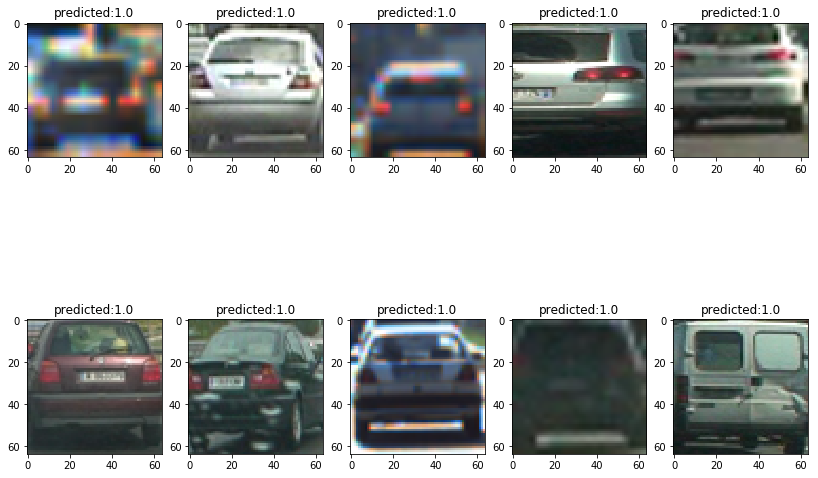

In [19]:
samples = np.random.choice(vehicle_filenames,10)
images = []
for sample in samples:
    images.append(imread(sample))
sample_car_features = extract_features(images, cspace=cspace, with_bin_spatial=True, with_color_hist=True, with_hog_features=True, orient=orient)
sample_car_features = np.array(sample_car_features).astype(np.float64)
sample_scaled = scaler.transform(sample_car_features)
predictions = clf.predict(sample_scaled)
images = [imread(sample) for sample in samples]
titles = ['predicted:' + str(p) for p in predictions]
plot_images(images, rows=2, titles=titles)

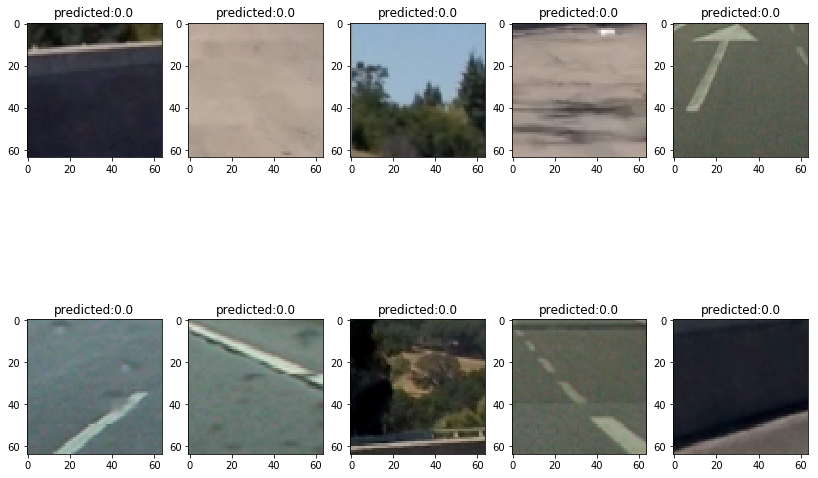

In [20]:
samples = np.random.choice(non_vehicle_filenames,10)
images = []
for sample in samples:
    images.append(imread(sample))
sample_car_features = extract_features(images, cspace=cspace, with_bin_spatial=True, with_color_hist=True, with_hog_features=True, orient=8)
sample_car_features = np.array(sample_car_features).astype(np.float64)
sample_scaled = scaler.transform(sample_car_features)
predictions = clf.predict(sample_scaled)
images = [imread(sample) for sample in samples]
titles = ['predicted:' + str(p) for p in predictions]
plot_images(images, rows=2, titles=titles)

## use sliding windows method to find car

In [21]:
def draw_boxes(img, bboxes, color=(0,0,255), thick=6):
    imcopy = np.copy(img)
    
    for box in bboxes:
        cv2.rectangle(imcopy, box[0], box[1], color, thick)
        
    return imcopy

def slide_window(img, x_start_stop=(None,None), y_start_stop=(None,None),xy_window=(64,64), xy_overlap=(0.5,0.5)):
    x_start = 0 if x_start_stop[0] == None else x_start_stop[0]
    x_stop = img.shape[1] if x_start_stop[1] == None else x_start_stop[1]
    y_start = 0 if y_start_stop[0] == None else y_start_stop[0]
    y_stop = img.shape[0] if y_start_stop[1] == None else y_start_stop[1]
    
    x_span = x_stop - x_start
    y_span = y_stop - y_start
    
    nx_pixel_per_step = np.int(xy_window[0] * (1 - xy_overlap[0]))
    ny_pixel_per_step = np.int(xy_window[1] * (1 - xy_overlap[1]))
    
    nx_buffer = np.int(xy_window[0] * xy_overlap[0])
    ny_buffer = np.int(xy_window[1] * xy_overlap[1])
    nx_windows = np.int((x_span - nx_buffer) / nx_pixel_per_step)
    ny_windows = np.int((y_span - ny_buffer) / ny_pixel_per_step)
    
    window_list = []
    
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            startx = xs * nx_pixel_per_step + x_start
            endx = startx + xy_window[0]
            starty = ys * ny_pixel_per_step + y_start
            endy = starty + xy_window[1]
            
            window_list.append(((startx, starty), (endx, endy)))
            
    return window_list


In [22]:
def search_windows(img, windows,clf, scaler):
    on_windows = []
    for window in windows:
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64,64))
        features = extract_image_features(test_img, cspace=cspace,with_bin_spatial=True, with_color_hist=True, with_hog_features=True, orient=orient)
        test_features = scaler.transform(np.array(features).reshape(1,-1))
        prediction = clf.predict(test_features)
        
        if prediction == 1:
            on_windows.append(window)
    return on_windows

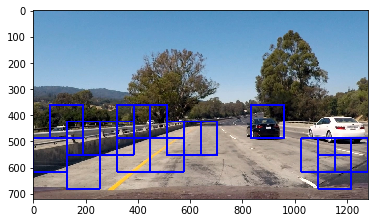

In [43]:
y_start_stop = (360, None)

image = imread('test_images/test1.jpg')

windows = slide_window(image, x_start_stop=(None,None), y_start_stop=y_start_stop,xy_window=(128,128))
hot_windows = search_windows(image, windows, clf, scaler)
window_img = draw_boxes(image, hot_windows)

plt.imshow(window_img)


Use hog sub-smapling window search to do extract hog features only once 

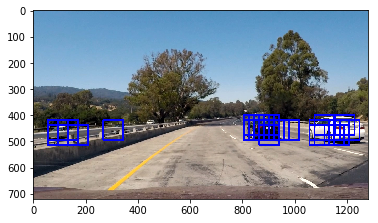

In [44]:
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,print=False):
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_to_search = img[ystart:ystop, :,:]
    ctrans_to_search = convert_color(img_to_search, cspace)
    if scale != 1:
        imshape = ctrans_to_search.shape
        ctrans_to_search = cv2.resize(ctrans_to_search, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_to_search[:,:,0]
    ch2 = ctrans_to_search[:,:,1]
    ch3 = ctrans_to_search[:,:,2]
    
    nxblocks = (ch1.shape[1] // pix_per_cell) - 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - 1
    nfeat_per_block = orient * cell_per_block ** 2
    
    window = 64
    nblocks_per_window = (window // pix_per_cell) - 1
    cells_per_step = 2
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    hogs = hog_features(ctrans_to_search, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog1 = hogs[0: len(hogs) / 3]
    hog2 = hogs[len(hogs)/3: 2 * len(hogs) / 3]
    hog3 = hogs[len(hogs) * 2 / 3:]
    
    windows = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb * cells_per_step
            xpos = xb * cells_per_step
            
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
            hog_feat_all = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            
            xleft = xpos * pix_per_cell
            ytop = ypos * pix_per_cell
            
            subimg = cv2.resize(ctrans_to_search[ytop:ytop+window, xleft:xleft+window],(64,64))
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)
            
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_feat_all))).reshape(1,-1)
            prediction = svc.predict(test_features)
            
            if prediction == 1:
                xbox_left = np.int(xleft * scale)
                ytop_draw = np.int(ytop * scale)
                win_draw = np.int(window* scale)
                windows.append(((xbox_left, ytop_draw + ystart), (xbox_left+win_draw, ytop_draw + win_draw + ystart)))
                cv2.rectangle(draw_img, (xbox_left, ytop_draw + ystart), (xbox_left+win_draw, ytop_draw + win_draw + ystart), (0,0,255),6)
                
    if print:
        plt.imshow(draw_img)
    return windows

ystart = 400
ystop = 656
scale = 1.2

img = imread('test_images/test1.jpg')
windows = find_cars(img, ystart,ystop, scale,clf, scaler, orient,8, 2, (32,32), 32, print=True)         
    

use threadhold to filter false positives and use lable to merge the same car

In [45]:
def add_heat(heatmap, bbox_list):
    for box in bbox_list:
        heatmap[box[0][1]:box[1][1],box[0][0]:box[1][0]] += 1
    return heatmap

def apply_threshold(heatmap, threshold):
    heatmap[heatmap <= threshold] = 0
    return heatmap

def draw_labeled_bboxes(img,labels):
    for car_number in range(1, labels[1] + 1):
        nonzero = (labels[0] == car_number).nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255),6)
        
    return img

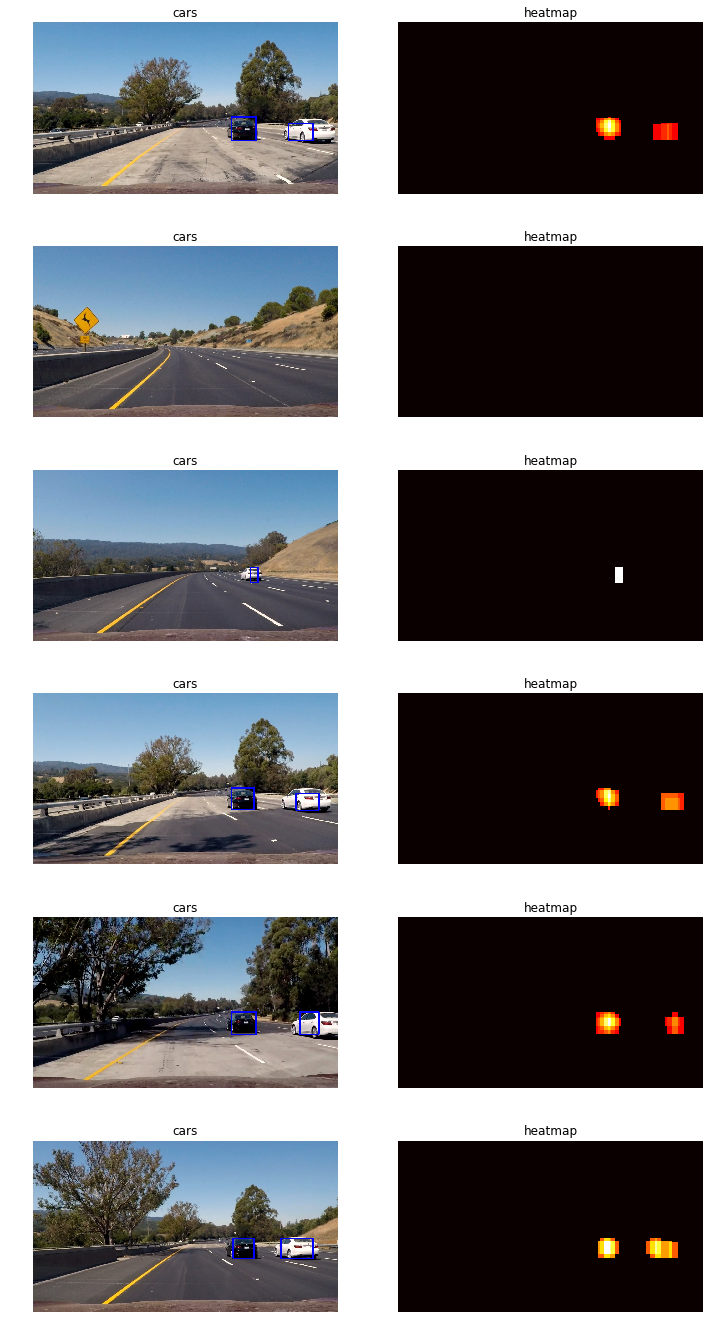

In [58]:
test_image_files = glob.glob('test_images/*.jpg')
out_images = []
out_titles = []
search_regions = [[400,656,1.5], [380,572,1.0]]
for image_file in test_image_files:
    image = imread(image_file)
    windows = []
    for region in search_regions:
        windows.extend(find_cars(image, region[0], region[1], region[2], clf, scaler, orient, 8, 2, (32,32), 32, print=False))
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    heat = add_heat(heat, windows)
    heat = apply_threshold(heat, 4)
    heatmap = np.clip(heat, 0, 255)
    
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    out_images.extend([draw_img, heatmap])
    out_titles.extend(['cars', 'heatmap'])
    
plot_images(out_images, rows=len(test_image_files), titles=out_titles, axis='off', figsize=(12,24))


## Video Process

In [63]:
import collections

heatmaps = collections.deque(maxlen=5)

def process_image(image):
    global heatmaps
    windows = []
    for region in search_regions:
        windows.extend(find_cars(image, region[0] , region[1], region[2], clf, scaler, orient, 8 , 2, (32,32), 32, print=False))
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    heat = add_heat(heat, windows)
    heatmaps.append(heat)
    sum_heatmap = np.array(heatmaps).sum(axis=0)
    
    heat = apply_threshold(sum_heatmap, min(len(heatmaps) * 1.5, 10))
    heatmap = np.clip(heat, 0, 255)
    
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    
    return draw_img


In [64]:
input_video = 'project_video.mp4'
output_video = 'project_output_video.mp4'
clip = VideoFileClip(input_video)
video_clip = clip.fl_image(process_image)
video_clip.write_videofile(output_video, audio=False)

[MoviePy] >>>> Building video project_output_video.mp4
[MoviePy] Writing video project_output_video.mp4


100%|█████████▉| 1260/1261 [29:38<00:01,  1.55s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_output_video.mp4 

